In [177]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon
import seaborn as sns

In [103]:
def visualize_hexagons(hexagons, color="blue", folium_map=None):

    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=20, tiles='cartodbpositron')
    else:
        m = folium_map
        
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
  
h3_address = h3.geo_to_h3(45.035470, 38.975313,  9) # 9 - индекс, определяющий размер гексагона                                                                                                     
visualize_hexagons([h3_address])

In [104]:
def visualize_polygons(geometry):
    
    lats, lons = get_lat_lon(geometry)
    
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=13, tiles='cartodbpositron')
    
    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name = 'boundary').add_to(m)
    
    return m

# выводим центроиды полигонов
def get_lat_lon(geometry):
    lon = geometry.apply(lambda x: x.x if x.type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.type == 'Point' else x.centroid.y)
    return lat, lon
  
# выгрузим границы Краснодара из OSM

cities = ['Saint-Petersburg, Russia']
polygon_cities = ox.geocode_to_gdf(cities) 
# посмотрим что получилось
visualize_polygons(polygon_cities['geometry'])
#polygon_cities

In [188]:
def create_hexagons(geoJson):
    
    polyline = geoJson['coordinates'][0]

    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
    m.add_child(my_PolyLine)

    hexagons = list(h3.polyfill(geoJson, 8))
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=3,color='red')
        m.add_child(my_PolyLine)
        
    polylines_x = []
    for j in range(len(polylines)):
        a = np.column_stack((np.array(polylines[j])[:,1],np.array(polylines[j])[:,0])).tolist()
        polylines_x.append([(a[i][0], a[i][1]) for i in range(len(a))])
        
    polygons_hex = pd.Series(polylines_x).apply(lambda x: Polygon(x))
        
    return m, polygons_hex, polylines
# polygon_hex , polylines - геометрии гексагонов в разных форматах

# сгенерим гексагоны внутри полигона г. Краснодар
geoJson = json.loads(gpd.GeoSeries(polygon_cities['geometry'][0]).to_json())
geoJson = geoJson['features'][0]['geometry']
geoJson = {'type':'Polygon','coordinates': [np.column_stack((np.array(geoJson['coordinates'][0])[:, 1],
                                                      np.array(geoJson['coordinates'][0])[:, 0])).tolist()]}

m, polygons, polylines = create_hexagons(geoJson)
m

In [108]:
def osm_query(tag, city):
    gdf = ox.geometries_from_place(city, tag).reset_index()
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    gdf = gdf[['city', 'object', 'type', 'geometry']]
    print(gdf.shape)
    return gdf
  
 # Выгрузим интересующие нас категории объектов 

tags = [
        {'amenity':'cafe'}, {'amenity':'fast_food'}, 
        {'amenity':'restaurant'}, {'amenity':'college'}, 
        {'amenity':'language_school'},  {'amenity':'school'},  
        {'amenity':'university'},  {'amenity':'atm'},  
        {'amenity':'bank'},  {'amenity':'clinic'},  
        {'amenity':'hospital'},  {'amenity':'pharmacy'},  
        {'amenity':'theatre'},  {'amenity':'townhall'},  
        #{'amenity':'bench'}, 
       ]

#tags = [{'amenity':True}]
cities = ['Saint-Petersburg, Russia']

gdfs = []
for city in cities:
    for tag in tags:
        gdfs.append(osm_query(tag, city))
        
# посмотрим что получилось
data_poi = pd.concat(gdfs)
data_poi.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})

# добавим координаты/центроиды
lat, lon = get_lat_lon(data_poi['geometry'])
data_poi['lat'] = lat
data_poi['lon'] = lon

(2805, 4)
(1867, 4)
(1278, 4)
(158, 4)
(72, 4)
(830, 4)
(205, 4)
(1792, 4)
(956, 4)
(368, 4)
(125, 4)
(1364, 4)
(114, 4)
(30, 4)


In [183]:
data_poi

,city,object,type,geometry,lat,lon
0,Saint-Petersburg,amenity,cafe,POINT (30.31199 59.95926),59.959262,30.311990
1,Saint-Petersburg,amenity,cafe,POINT (30.32051 59.95450),59.954505,30.320509
2,Saint-Petersburg,amenity,cafe,POINT (30.28913 59.92477),59.924773,30.289133
3,Saint-Petersburg,amenity,cafe,POINT (30.29601 59.95548),59.955479,30.296009
4,Saint-Petersburg,amenity,cafe,POINT (30.31475 59.96094),59.960937,30.314754
...,...,...,...,...,...,...
25,Saint-Petersburg,amenity,townhall,POINT (30.27256 59.88522),59.885216,30.272555
26,Saint-Petersburg,amenity,townhall,POINT (30.40232 59.86520),59.865202,30.402316
27,Saint-Petersburg,amenity,townhall,POINT (30.27844 59.89454),59.894536,30.278443
28,Saint-Petersburg,amenity,townhall,POINT (30.31842 59.88512),59.885122,30.318418


In [189]:
# sjoin - spatial join - пересекаем гексагоны с объектами (определяем какие объекты находятся в разрезе каждого гексагона)

pois = gpd.GeoDataFrame(data_poi, geometry=gpd.points_from_xy(data_poi.lon, data_poi.lat))

hs = pd.DataFrame(polygons, columns = ['geometry'])
hs['polylines'] = polylines
hs['geometry'] = hs['geometry'].astype(str)
geometry_uniq = pd.DataFrame(hs['geometry'].drop_duplicates())
geometry_uniq['id'] = np.arange(len(geometry_uniq)).astype(str)
hs = hs.merge(geometry_uniq, on = 'geometry')
hs['geometry'] = hs['geometry'].apply(wkt.loads)
hs = gpd.GeoDataFrame(hs, geometry='geometry')

itog_table = gpd.sjoin(hs, pois, how='left', predicate='intersects')
itog_table = itog_table.dropna()
itog_table.head()

,geometry,polylines,id,index_right,city,object,type,lat,lon
0,"POLYGON ((30.46957 59.94678, 30.47773 59.94780...","[(59.94677602196707, 30.469574523324155), (59....",0,32.0,Saint-Petersburg,amenity,restaurant,59.947546,30.473551
0,"POLYGON ((30.46957 59.94678, 30.47773 59.94780...","[(59.94677602196707, 30.469574523324155), (59....",0,10.0,Saint-Petersburg,amenity,bank,59.947785,30.474115
0,"POLYGON ((30.46957 59.94678, 30.47773 59.94780...","[(59.94677602196707, 30.469574523324155), (59....",0,441.0,Saint-Petersburg,amenity,restaurant,59.947993,30.473896
0,"POLYGON ((30.46957 59.94678, 30.47773 59.94780...","[(59.94677602196707, 30.469574523324155), (59....",0,749.0,Saint-Petersburg,amenity,bank,59.948083,30.476157
0,"POLYGON ((30.46957 59.94678, 30.47773 59.94780...","[(59.94677602196707, 30.469574523324155), (59....",0,1954.0,Saint-Petersburg,amenity,cafe,59.948106,30.476237


In [190]:
itog_table.groupby('type')

In [191]:
def create_choropleth(data, json, columns, legend_name, feature, bins):
    
    lat, lon = get_lat_lon(data['geometry'])

    m = folium.Map(location=[sum(lat)/len(lat), sum(lon)/len(lon)], zoom_start=13, tiles='cartodbpositron')
    
    folium.Choropleth(
        geo_data=json,
        name="choropleth",
        data=data,
        columns=columns,
        key_on="feature.id",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color = 'black',
        bins = bins

    ).add_to(m)

    folium.LayerControl().add_to(m)

    return m
  
# подготовим данные 
itog_table['geometry'] = itog_table['geometry'].astype(str) #для groupby
itog_table['id'] = itog_table['id'].astype(str) #для Choropleth
agg_all = itog_table.groupby(['geometry','type','id'], as_index = False).agg({'lat':'count'}).rename(columns = {'lat':'counts'})
agg_all['geometry'] = agg_all['geometry'].apply(wkt.loads) #возвращаем формат геометрий

agg_all_cafe = agg_all.query("type == 'fast_food'")[["geometry","counts",'id']]
agg_all_cafe['id'] = agg_all_cafe['id'].astype(str)
data_geo_1 = gpd.GeoSeries(agg_all_cafe.set_index('id')["geometry"]).to_json()

create_choropleth(agg_all_cafe, data_geo_1, ["id","counts"], 'Cafe counts', 'counts',9)
    

/Users/ivanesipov/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


/Users/ivanesipov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='counts', ylabel='Density'>

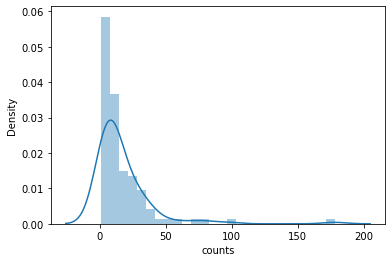

In [187]:
sns.distplot(agg_all_cafe.sort_values(by = 'counts', ascending = False).counts, kde = True)

In [91]:
gdf_aparts = ox.geometries_from_place(city, {'building' : 'apartments'}).reset_index()
# полнота building:levels (этажи)
print(np.round(len(gdf_aparts['building:levels'].dropna())/len(gdf_aparts['building:levels']), 2))

# полнота building:flats (квартиры)
#print(np.round(len(gdf_aparts['building:flats'].dropna())/len(gdf_aparts['building:flats']), 2),gdf_aparts['building:flats'].dropna()/len(gdf_aparts['building:flats']), 2)


1.0


In [92]:
# добавим фичу - население

lat_g, lon_g = get_lat_lon(gdf_aparts['geometry'])
gdf_aparts['lat'] = lat_g
gdf_aparts['lon'] = lon_g

itog_table_people = itog_table.merge(gdf_aparts[['lat', 'lon', 'building:levels']], on = ['lat', 'lon'], how = 'left')
itog_table_people['building:levels'] = itog_table_people['building:levels'].fillna(1)
itog_table_people = itog_table_people.rename(columns = {'building:levels' : 'levels'})

apartments = ['apartments' , 'dormitory']
houses = ['house', 'semidetached_house', 'detached', 'terrace']
people_ctn = []

# в среднем возьмем 3 чел. на семью

for i in range(len(itog_table_people)):
    
    if itog_table_people['type'].iloc[i] in apartments:
        
        people = int(itog_table_people['levels'].iloc[i])*10*3
        
    elif itog_table_people['type'].iloc[i] in houses:
        
        people = int(itog_table_people['levels'].iloc[i])*3
        
    else:
        people = 'not living area'
        
    people_ctn.append(people)
    
itog_table_people['count_people'] = people_ctn

table_people = itog_table_people.query("count_people != 'not living area'")
table_people['count_people'] = table_people['count_people'].astype(int)

/Users/ivanesipov/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [93]:
table_people

,geometry,polylines,id,index_right,city,object,type,lat,lon,levels,count_people
22,"POLYGON ((37.1537603818409 55.96284083764721, ...","[(55.962840837647214, 37.153760381840904), (55...",8,446.0,Zelenograd,building,apartments,55.964018,37.154257,16,480
23,"POLYGON ((37.1537603818409 55.96284083764721, ...","[(55.962840837647214, 37.153760381840904), (55...",8,457.0,Zelenograd,building,apartments,55.964165,37.155379,16,480
26,"POLYGON ((37.23891348825849 55.99865340136407,...","[(55.99865340136407, 37.23891348825849), (55.9...",10,212.0,Zelenograd,building,apartments,55.996950,37.234653,14,420
28,"POLYGON ((37.23891348825849 55.99865340136407,...","[(55.99865340136407, 37.23891348825849), (55.9...",10,205.0,Zelenograd,building,apartments,55.997359,37.235104,14,420
34,"POLYGON ((37.23891348825849 55.99865340136407,...","[(55.99865340136407, 37.23891348825849), (55.9...",10,209.0,Zelenograd,building,apartments,55.997807,37.233660,14,420
...,...,...,...,...,...,...,...,...,...,...,...
1470,"POLYGON ((37.2292254679331 55.98909027226156, ...","[(55.989090272261556, 37.2292254679331), (55.9...",367,161.0,Zelenograd,building,apartments,55.989433,37.226271,12,360
1473,"POLYGON ((37.2292254679331 55.98909027226156, ...","[(55.989090272261556, 37.2292254679331), (55.9...",367,153.0,Zelenograd,building,apartments,55.990010,37.225382,14,420
1474,"POLYGON ((37.2292254679331 55.98909027226156, ...","[(55.989090272261556, 37.2292254679331), (55.9...",367,157.0,Zelenograd,building,apartments,55.990013,37.226666,10,300
1475,"POLYGON ((37.2292254679331 55.98909027226156, ...","[(55.989090272261556, 37.2292254679331), (55.9...",367,417.0,Zelenograd,building,apartments,55.990389,37.227609,14,420


In [94]:
def create_heatmap(data, lat_lon_feature):
    
    m = folium.Map(location=[sum(data['lat'])/len(data['lat']), sum(data['lon'])/len(data['lon'])], zoom_start=13, tiles='cartodbpositron')
    
    HeatMap(data[lat_lon_feature].groupby(lat_lon_feature[0:2]).sum().reset_index().values.tolist(), 
                    radius = 70, min_opacity = 0.05, max_val = int((data[lat_lon_feature[2]]).quantile([0.75])), blur=30).add_to(m)
    return m
  
# карта плотности населения
create_heatmap(table_people, ['lat', 'lon', 'count_people'])

/var/folders/1f/1t7knmh95bg_g1s30p6r8mp40000gn/T/ipykernel_63451/3818249516.py:5: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  HeatMap(data[lat_lon_feature].groupby(lat_lon_feature[0:2]).sum().reset_index().values.tolist(),
